In [81]:
import numpy as np
import sympy as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
# from itertools import combinations
import warnings
warnings.filterwarnings("ignore")

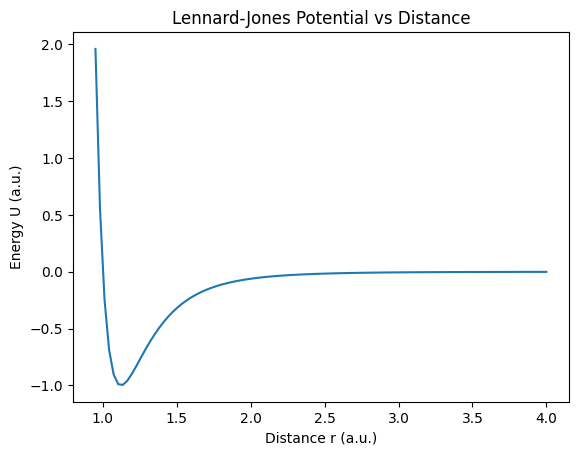

In [82]:
class Symbolic():
    epsilon = sp.Symbol("epsilon")
    sigma = sp.Symbol("sigma")
    r = sp.Symbol("r")
    lj_potential = 4*epsilon*((sigma/r)**12 - (sigma/r)**6)
    lj_force = -sp.diff(lj_potential,r)


func_lj_potential = sp.lambdify(Symbolic.r,Symbolic.lj_potential.subs({Symbolic.epsilon:1, Symbolic.sigma:1}))
func_lj_force = sp.lambdify(Symbolic.r,Symbolic.lj_force.subs({Symbolic.epsilon:1, Symbolic.sigma:1}))


x = np.linspace(0.95,4,100)
plt.plot(x,func_lj_potential(x))

plt.title("Lennard-Jones Potential vs Distance")
plt.xlabel("Distance r (a.u.)")
plt.ylabel("Energy U (a.u.)")
plt.show()


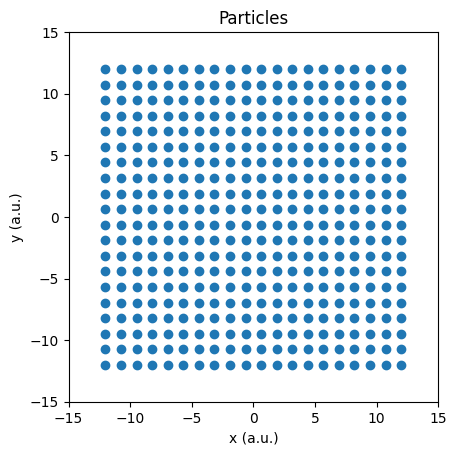

In [93]:
# SET UP RANDOM INITIAL CONDITIONS
rng = np.random.default_rng(seed=102)

# EPSILON = 1
# SIGMA = 1
# M = 1
X_U_MIN = 2**(1/6)*1
CONTAINER_FACTOR = 1.5
LATTICE_CONSTANT = 1.2

L = 20
N = L*L
DIM = 2
X_LOWER,X_UPPER = -(L/2)*CONTAINER_FACTOR,(L/2)*CONTAINER_FACTOR
X_LATTICE_LOWER,X_LATTICE_UPPER = -(L/2)*LATTICE_CONSTANT,(L/2)*LATTICE_CONSTANT
# V_LOWER,V_UPPER = -0.1, 0.1
V_SPREAD = 1
# create random x and y coordinates for each particle, between 0 and 1
# r = rng.uniform(X_LOWER, X_UPPER, (DIM,N))
# r = rng.uniform(X_LOWER, X_UPPER, (DIM,N))

def generate_square_lattice(A,B):
    return np.meshgrid(*[np.linspace(X_LATTICE_LOWER,X_LATTICE_UPPER,L) for i in range(DIM)])


r = generate_square_lattice(L,L)
# print(r)
r = np.vstack(list(map(np.concatenate,r)))
# print(r)

# r = np.array([[0,0],[0.5,1],[1,0.3]]).T
# v = rng.uniform(V_LOWER, V_UPPER, (DIM,N))
v = rng.normal(0, V_SPREAD, (DIM,N))
plt.title("Particles")
plt.xlim(X_LOWER, X_UPPER)
plt.ylim(X_LOWER, X_UPPER)
plt.xlabel("x (a.u.)")
plt.ylabel("y (a.u.)")
plt.gca().set_aspect('equal')
plt.scatter(*r)
plt.show()

In [94]:
x = r[0]
def pair_displacements_1D(x):
    return -np.diff(np.meshgrid(x,x),axis=0)[0]
    # return np.diff(np.asarray(combinations(x,2)),axis=1).ravel()

def pair_displacements(r):
    return np.array([pair_displacements_1D(x) for x in r])

def magnitudes(v):
    return np.sqrt(np.sum(v**2,axis=0))

def pair_distances(r):
    return magnitudes(pair_displacements(r))

displacements = pair_displacements(r)
distances = pair_distances(r)
unit_displacements = pair_displacements(r) / pair_distances(r)
# unit_displacements[np.isnan(unit_displacements)] = 0

potential_energies = func_lj_potential(distances)
potential_energies[np.isnan(potential_energies)] = 0
potential_energy = potential_energies.sum()
potential_energy_av = potential_energy / N
print(potential_energy_av)

lj_forces = - unit_displacements * func_lj_force(distances)
lj_forces[np.isnan(lj_forces)] = 0
net_lj_force = lj_forces.sum(axis=2)
# print(lj_forces)
# print(net_lj_force)

# plt.quiver(np.repeat(r[0],N),np.repeat(r[1],N), displacements[0,:,:].ravel(),displacements[1,:,:].ravel(), angles="xy", scale=1, scale_units="xy")
def plot_each_arrow(r,A,color=None):
    if color is None: color=np.ones(len(A[0])**2)
    return plt.quiver(
        *[np.repeat(x,N)for x in r],
        *[A[i,:,:].ravel() for i in range(DIM)],
        color,
        angles="xy", scale=1, scale_units="xy")
# plot_each_arrow(r,lj_forces)

# plt.title("Displacement Vectors")
# plt.xlabel("x (a.u.)")
# plt.ylabel("y (a.u.)")
# plot_each_arrow(r,displacements,distances)
# plt.show()

# plt.title("Lennard-Jones Force Vectors")
# plt.xlim(X_LOWER*1.2, X_UPPER*1.2)
# plt.ylim(X_LOWER*1.2, X_UPPER*1.2)
# plt.xlabel("x (a.u.)")
# plt.ylabel("y (a.u.)")
# plot_each_arrow(
#     r,
#     lj_forces / magnitudes(lj_forces),
#     np.clip(magnitudes(lj_forces),0,EPSILON),
# )
# plt.colorbar()
# plt.text(X_LOWER,X_LOWER, "Forces are clipped with upper bound 1")
# plt.show()

# plt.title("Lennard-Jones Net Force Vectors")
# plt.xlim(X_LOWER*1.2, X_UPPER*1.2)
# plt.ylim(X_LOWER*1.2, X_UPPER*1.2)
# plt.xlabel("x (a.u.)")
# plt.ylabel("y (a.u.)")
# plt.quiver(*r, *net_lj_force, angles="xy", )
# plt.show()

-3.3854910885622673


In [95]:
def calc_F_lj(r):
    unit_displacements = pair_displacements(r) / pair_distances(r)
    lj_forces = - unit_displacements * func_lj_force(distances)
    lj_forces[np.isnan(lj_forces)] = 0
    net_lj_force = lj_forces.sum(axis=2)
    return net_lj_force

def calc_F_bounds(r):
    return -np.heaviside(X_LOWER-r,0)*(r-X_LOWER)**10 + -np.heaviside(r-X_UPPER,0)*(r-X_UPPER)**10

def calc_a(r):
    F_lj = calc_F_lj(r)
    F_grav = np.array([0,-0.5])
    F = F_lj 
    # F_bounds = calc_F_bounds(r)
    # F += F_bounds
    a = F
    return a

def leapfrog_step(r,v,dt):
    a = calc_a(r)
    v = v + a*dt/2
    r = r + v*dt
    a = calc_a(r)
    v = v + a*dt/2
    return r,v

def wall_boundary_conds(r,v):
    v *= 1 - (np.heaviside(r-X_UPPER,0) * np.heaviside(v,0))*2
    v *= 1 - (np.heaviside(X_LOWER-r,0) * np.heaviside(-v,0))*2
    return r,v

def boundary_conds(r,v):
    return wall_boundary_conds(r,v)

def step_state(r,v,dt):
    r,v = leapfrog_step(r,v,dt)
    r,v = boundary_conds(r,v)
    return r,v

In [96]:
def time_evolution(r,v,steps,dt):
    rs = np.zeros((steps,r.shape[0], r.shape[1]))
    vs = np.zeros((steps,r.shape[0], r.shape[1]))
    rs[0] = r.copy()
    vs[0] = v.copy()
    for i in range(1,steps):
        r,v = step_state(r,v,dt)
        rs[i] = r.copy()
        vs[i] = v.copy()
    return rs, vs

In [97]:
t,dt = 2,0.01
steps = int(t//dt)
rs, vs = time_evolution(r,v,steps,dt)

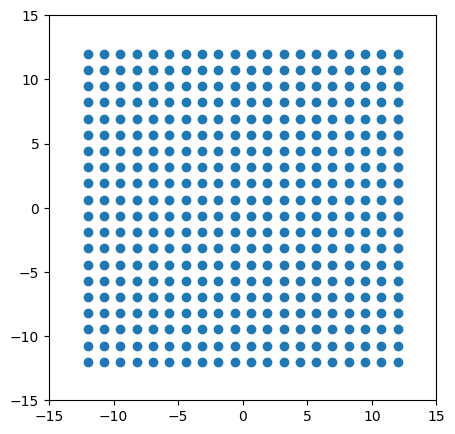

In [98]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
def animation_frame(i):
    ax.clear()
    ax.scatter(*rs[i])
    ax.set_xlim(X_LOWER, X_UPPER)
    ax.set_ylim(X_LOWER, X_UPPER)

lj_anim = animation.FuncAnimation(fig, animation_frame, frames=steps, interval=10)
lj_anim.save("test.gif", writer="pillow", fps=30, dpi=100)